# Wizualizacja dużych danych przestrzennych w JupyterLab z użyciem cenagisVisualization
### Opis
Biblioteki do pracy z dużymi danymi przestrzennymi w Spark takie jak GeoMesa czy RasterFrames nie obsługują procesu wizualizacji danych. Zadanie to umożliwia moduł biblitoeki cenagis - cenagisVisualization. Pozwala on na wyświetlenie na mapie opartej o leaflet danych przechowywanych w postaci Spark `DataFrame` (zarówno wektorowych jak i restrowych). Ze względu na specyfikę dużych danych przestrzennych udostępniono kilka metod wizualizacji, których wybór powinien być uzależniony od wielkości danych przechowywanych w Spark `DataFrame`. Poniżej zaprezentowano możliwości modułu cenagisVisualization wraz z opisem zastosowań poszczególnych metod wizualizacji.

### Narzędzia/biblioteki
__cenagis__ - Inicjalizacja kontekstu Spark, dostęp do danych przestrzenncyh na HDFS<br>
__cenagisVisualization__ - Wizualizacja dużych danych przestrzennych na mapie<br>
__pySpark__ - Operacje na danych w Spark<br>
__branca__ - Obsługa palet kolorystycznych <br>
__GeoServer__ - Usługa serwująca dane przestrzenne w formie usług WMS/WMTS
### Literatura
Dokumentacja ipyleaflet - https://ipyleaflet.readthedocs.io/en/latest/index.html

Dokumentacja narzędzia geoserver - https://docs.geoserver.org

## Inicjalizacja kontekstu Spark i mapy w bocznym panelu
Pracę z modułem `cenagis.visualization` należy zacząć od inicjalizacji kontekstu Spark oraz wywołania funkcji `init_map`. Spowoduje to wyświetlenie mapy po prawej stronie ekranu.

>Uwaga! `init_map` należy wywoływać po inicjalizacji kontekstu Spark. Bez zainicjalizowanego kontekstu funkcja ta zwróci błąd.

In [1]:
import cenagis
import pyspark.sql.functions as F
from branca.colormap import linear
import geopyspark as gps
import ipyleaflet as ll
import pyrasterframes.rf_ipython  

spark=cenagis.spark.init_spark(app_name='visualizationExperiments',
                                              executor_cores=4,
                                              executor_memory='8g',
                                              executor_gpu=0,
                                              max_cpu=16).withRasterFrames()
cenagis.visualization.map.init_map()

Spark UI available at: https://3bd8a9f1-1221-44a0-84a4-bae5eb304958.dcsvc.cenagis.edu.pl


## Wczytanie danych testowych
Na potrzeby prezentacji możliwości modułu wczytane zostaną przykładowe dane przestrzenne. Dla poszczególnych `DataFrame` doliczane są pewne numeryczne atrybuty (powierzchnia, odległość od jakiegoś punktu), które wykorzystywane są podczas wizualizacji.

In [2]:
wojewodztwa = cenagis.geomesa.get_geomesa_dataframe(geomesa_catalog="cenagis_pre.prg",geomesa_feature="wojewodztwa").withColumn("area",F.expr("ST_Area(geom)")).cache()
addr = cenagis.geomesa.get_geomesa_dataframe(geomesa_catalog="cenagis_pre.prg",geomesa_feature="adresy").withColumn("distance",F.expr('st_distanceSphere(geometry,st_makePoint(17, 52))')).cache()
powiaty = cenagis.geomesa.get_geomesa_dataframe(geomesa_catalog="cenagis_pre.prg",geomesa_feature="powiaty").withColumn("area",F.expr("ST_Area(geom)")).cache()
gminy = cenagis.geomesa.get_geomesa_dataframe(geomesa_catalog="cenagis_pre.prg",geomesa_feature="gminy").withColumn("area",F.expr("ST_Area(geom)")).cache() 

## Wizualizacja danych wektorowych lokalnie
W tej części wizualizacja odbywa się na podstawie konwersji Spark `DataFrame` do GeoPandas `Dataframe`, a następnie przekazania danych do przeglądarki internetowej jako obiektów Leaflet w JavaScript. Proces ten jest stosunkowo powolny, dlatego należy go stosować do niewielkich ilości danych i dla złożonych geometrii stosować upraszczanie, za pomocą parametrów
```python
,simplify=True,tolerance=0.0001
```
Domyślne uproszczenie zakłada tolerancję na poziomie ok 10 m.

### Prosta wizualizacja danych wektorowych
Pierwsza z funkcji - `add_vector_layer` służy do prostego wyświetlenia obiektów na mapie. Do renderowania używany jest predefiniowany styl. Domyślne parametry wyglądają w sposób nastęujący:
```python
cenagis.visualization.map.add_vector_layer(
    df,
    name='Layer',
    style={},
    hover_style={'fillColor': 'red', 'fillOpacity': 0.2},
    point_style={'radius': 1, 'opacity': 0.4, 'fillOpacity': 0.2},
    simplify=False,
    tolerance=0.0001,
    preserve_topology=True,
)
```
Funkcja `remove_all_layers` spowoduje usunięcie wcześniejszych warstw wygenerowanych na mapie.

In [3]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_vector_layer(df=wojewodztwa,name="wojewodztwa",style={},simplify=True,tolerance=0.0001)

Ta sama metoda użyta do wizualizacji danych punktowych. W tym wypadku styl zostanie odczytany z atrybutu `point_style`, ponieważ warstwa zawiera wyłącznie dane punktowe.

In [5]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_vector_layer(df=addr.where("miejscowosc='Wrocław'").limit(5000),name="adresy",simplify=False,tolerance=0.0001)

### Wizualizacja danych za pomocą kartogramu
Dostępna jest również wizualizacja wartości przechowywanych w kolumnie Spark `DataFrame` w formie kartogramu. Służy do tego funkcja `add_choropleth_layer`. Do wizualizacji za pomocą kartogramu używane są nastęujące wartości domyślne:
```python
cenagis.visualization.map.add_choropleth_layer(
    df,
    attrName,
    name='Layer',
    colormap=linear.YlOrRd_04,
    border_color='black',
    style={'fillOpacity': 0.5},
    point_style={'radius': 2, 'opacity': 0.5, 'fillOpacity': 0.7},
    hover_style={'fillColor': 'red', 'fillOpacity': 0.2},
    simplify=False,
    tolerance=0.0001,
    preserve_topology=True,
)
```

aby wyświetlić dostępne palety kolorów należy uruchomić poniższy kod (uwaga, ładowanie wszystkich palet może zająć dłuższy czas)
```python
linear
```

Poniżej do wizualizacji używany jest atrybut `area`, natomiast skala kolorów budowana jest w sposób automatyczny i jest liniowa.

In [6]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_choropleth_layer(df=powiaty,attr_name='area',name="powiaty",simplify=True,tolerance=0.0001)

Analogiczna wizualizacja dla gmin - czas wykonania poniższej komórki będzie dłuższy ze względu na większą liczbę obiektów do wyświetlenia.

In [6]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_choropleth_layer(df=gminy,attr_name='area',name="gminy",simplify=True,tolerance=0.0001)

W formie kartogramu można wizualizować również punkty. Ograniczono ich liczbę do 5000 obiektów, aby nie przeciążyć silnika wizualizacji. Biblioteka nie jest jeszcze wyposażona w limity wyświetlania obiektów, a więc trzeba ich liczbę ograniczyć przed przekazaniem obiektu do modułu wizualizacji.

In [7]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_choropleth_layer(df=addr.where("miejscowosc='Wrocław'").limit(5000),attr_name='distance',name="adresy",simplify=False,tolerance=0.001)

### Wizualizacja punktów w formie klastrów
Punkty można dodatkowo zwizualizować w formie klastra punktów (funkcja `add_pointcluster_layer`). Ta technika pozwala na wyświetlenie dużej liczby obiektów punktowych na mapie, które będą grupować się w klastry wraz z oddaleniem widoku mapy.

In [8]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_pointcluster_layer(df=addr.limit(10000),name="adresy")

## Wizualizacja za pomocą wbudowanego oprogramowania GeoServer
W przypadku, gdy dane są zbyt duże, aby możliwe były do wizualizacji przy pomocy standardowych powyższych metod, należy zmienić podejście do ich wizualizacji. Większe zasoby danych można zwizualizować w postaci usługi WMS/WMTS wyświetlonej na podkładzie mapowym.

Wraz z JupyterLab użytkownik otrzymuje własny GeoServer (narzędzie zdolne do serwowania różnorodnych danych przestrzennych w formie usług WMS/WMTS). GeoServer dostęny jest spoza Jupyter, a jego adres można uzyskać wywołując poniższy kod:
```python
cenagis.geoserver.address.get_external_address()
```

Dane logowania<br>
login: admin<br>
hasło: geoserver

In [3]:
cenagis.geoserver.get_external_address()

'https://218c0503-e25b-422a-9d18-9284ba7e39fe.dcsvc.cenagis.edu.pl/geoserver/'

Zaawansowani użytkownicy mogą wykorzystać GeoServer bezpośrednio do wizualizacji danych przechowywanych w postaci plików GeoMesaFS na HDFS z użyciem własnoręcznie zdefiniowanych plików SLD i parametrów wizualizacji. Moduł wizualizacji udostępnia jednak funkcje do automatycznego generowania i udostępniania odpowiedniej usługi z poziomu interfejsu języka Python.

### Konwersja danych ze Spark DataFrame do GeoPackage i publikacja za pomocą GeoServer
W celu publikacji przy pomcy GeoServer dane ze Spark `DateFrame` muszą być wcześniej zapisane w formie interpretowalnej przez to narzędzie. Jest to plik GeoPackage, który jest następnie automatycznie odczytywany przez GeoServer i publikowany jako usługa.

Poniższy kod pozwala na publikację danych w formie GeoPackage za pomocą GeoServer. Jeśli plik GeoPackage już istnieje, dane są do niego dopisywane. Wymagane jest przekazanie `DataFrame` oraz wskazanie nazwy warstwy docelowej. Istnieje możliwość określnia nazwy `workspace` i `datastore`, które w razie potrzeby zostaną automatycznie utworzone.
```python
cenagis.geoserver.publishing.publish_dataframe_as_gpkg(
    df,
    layerName,
    workspace='cenagis',
    datastoreName='temp',
)
```

In [3]:
cenagis.geoserver.publish_dataframe_as_gpkg(addr.where("miejscowosc='Wrocław'"),'adresy')

'cenagis:adresy'

### Stylizacja publikowanej wartswy
Warstwa publikowana jest z domyślnym stylem oferowanym przez GeoServer. Można zmodyfikować ją z poziomu interfejsu Geoserver poprzez bezpośrednią edycję plików SLD, lub użyć funkcji generującej styl:
```python
cenagis.geoserver.style.create_simple_style(
    polygon=True, #czy wygenerwać styl dla poligonu
    line=True,#czy wygenerwać styl dla linii
    point=True,#czy wygenerwać styl dla punktu
    PointSize='3', #wielkość punktu
    MarkWellKnownName='circle', #symbol punktu
    fill='#14afe3', #kolor wypełnienia punktu/poligonu
    fillOpacity='0.5', #przezroczystość wypełnienia punktu/poligonu
    stroke='#000000', #kolor obrysu punktu/linii/poligonu
    strokeWidth='1',#szerokość obrysu punktu/linii/poligonu
    strokeOpacity='0.7'#przezroczystość obrysu punktu/linii/poligonu
)
```

In [4]:
mysld=cenagis.geoserver.create_simple_style()

Tak utworzony styl może zostać opublikowany w katalogu styli GeoServer.

In [5]:
cenagis.geoserver.upload_style("mysld",mysld)

po czym może zostać wykorzystany do wizualizacji w postaci usługi WMS. Poniższa funkcja spowoduje wyświetlenie opublikowanej wcześniej usługi na mapie z wykorzystaniem zadanego stylu.

In [6]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_local_wms_layer('cenagis:adresy',style='mysld')

W podobny sposób można wygenerować styl dla kartogramu:
```python
cenagis.geoserver.style.create_choropleth_style(
    df, #Dataframe
    attr, #Atrybut do wizualizacji
    polygon=True, #Czy wygenerować styl dla poligonu
    line=False, #Czy wygenerować styl dla linii
    point=False,#Czy wygenerować styl dla punktu
    colormap=linear.YlOrRd_04, #domyśłna paleta kolorów
    invert_colormap=False, # czy odwrócić paletę kolorów
    bins=5, # liczba przedziałów
    point_size='3', #wielkość punktu
    geometry_types=('polygon',), #symbol punktu
    fill_opacity='0.5', # przezroczystość wypełnienia punktu/poligonu
    stroke_width='1', # szerokość obrysu
    stroke_opacity='0.7', # przezroczystość obrysu
)
```


In [3]:
mysldchoro=cenagis.geoserver.style.create_choropleth_style(gminy,'area')
cenagis.geoserver.publishing.publish_dataframe_as_gpkg(gminy,'gminy')
cenagis.geoserver.style.upload_style("mysldchoro",mysldchoro)
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_local_wms_layer('cenagis:gminy',style='mysldchoro')

korzystając z biblioteki branca, można określić inną paletę barw. Istnieje również możliwość odwrócenia jednej z istniejących palet. 
```python
mysldchoro=cenagis.geoserver.style.create_choropleth_style(gminy,'area',colormap=linear.RdYlGn_05,invert_colormap=True)
```

In [5]:
mysldchoro2=cenagis.geoserver.style.create_choropleth_style(gminy,'area',colormap=linear.RdYlGn_05,invert_colormap=True)
cenagis.geoserver.upload_style("mysldchoro2",mysldchoro2)

W celu wyświetlenia legendy podczas wizualizacji należy ustawić flagę `add_legend` na `True`.

In [6]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_local_wms_layer('cenagis:gminy',style='mysldchoro2',add_legend=True)

## Modyfikacja mapy
Moduł cenagisVisualization opiera się na bibliotece ipyleaflet. Istnieje więc możliwość uzyskania dostępu bezpośrednio do obiektu mapy.

In [7]:
side_map = cenagis.visualization.map.map

Jest to obiekt mapy ipyleaflet, przy pomocy którego można dodać do mapy nowe kontrolki czy warstwy. Więcej informacji o manpiulacji mapą z użyciem biblioteki ipyleaflet znajduje się w [notatniku dotyczącym tego narzędzia](../Basics/ClassicNotebooks/jupyter_geovisualization.ipynb).

In [8]:
side_map.add_control(ll.DrawControl())

## Wizualizacja danych rastrowych
Moduł cenagisVisualization posiada możliwość wizualizacji danych rastrowych zgodnych z biblioteką RasterFrames przechowywanych w formie Spark `DataFrame`.

proj_raster_path,proj_raster
hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2,
hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2,
hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2,
hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2,
hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2,

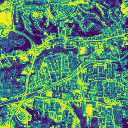
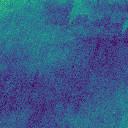
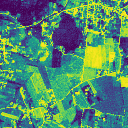
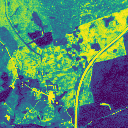
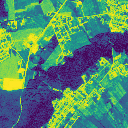

In [2]:
df = spark.read.raster('hdfs:///data_pre/sentinel/IMG_DATA/R10m/T34UCF_20210714T100029_B02_10m.jp2')
df

Służy do tego funkcja `add_raster_layer`. Przyjmuje ona wejściowy Spark DataFrame, unikalną nazwę warstwy oraz paletę kolorów. Wspiera ona palety dostępne w bibliotece matplotlib. W tym przypadku wykorzystana zostanie paleta *Greys*. Lista palet kolorystycznych dostępna jest pod adresem https://matplotlib.org/stable/tutorials/colors/colormaps.html.

In [3]:
cenagis.visualization.map.remove_all_layers()
cenagis.visualization.map.add_raster_layer(df,name='Sentinel Raster Data',colormap='Greys')

### Wyczyszczenie katalogu
Po zakończonej pracy można wyczyścić konfigurację geoserver'a oraz usunąć katalog z danymi. Spowoduje to usunięcie utworzonych plików Geopackge i styli.

In [4]:
cenagis.geoserver.clean_catalog_and_data()
spark.stop()